# Imports

In [1]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay


# Turn data into DataFrame

In [2]:
parasitized_path = './cell_images/Parasitized'
uninfected_path = './cell_images/Uninfected'

data = []
for file in os.listdir(parasitized_path):
    if not ( file.endswith(".png")):
        continue
    data.append([os.path.join(parasitized_path, file), 'parasitized'])

for file in os.listdir(uninfected_path):
    if not ( file.endswith(".png")):
        continue
    data.append([os.path.join(uninfected_path, file), 'uninfected'])

df = pd.DataFrame(data, columns=['file_path', 'label'])

print(df.head())


                                           file_path        label
0  ./cell_images/Parasitized\C100P61ThinF_IMG_201...  parasitized
1  ./cell_images/Parasitized\C100P61ThinF_IMG_201...  parasitized
2  ./cell_images/Parasitized\C100P61ThinF_IMG_201...  parasitized
3  ./cell_images/Parasitized\C100P61ThinF_IMG_201...  parasitized
4  ./cell_images/Parasitized\C100P61ThinF_IMG_201...  parasitized


# Rezize and flatten the images 

In [3]:
def load_data(df):
    images = []
    labels = []
    for _, file_path, label in df.itertuples():
        img = cv2.imread(file_path)
        if img is not None:
            img = cv2.resize(img, (64, 64))
            images.append(img.flatten())
            labels.append(True if label == 'parasitized' else False)

    return np.array(images), np.array(labels)


# Get data and prepare it for training 

In [4]:
X, y = load_data(df)

In [5]:
scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=54)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
log_pca = PCA(n_components=70, random_state=0)
log_X_train = log_pca.fit_transform(X_train)
log_X_test = log_pca.transform(X_test)

In [6]:
knn_pca = PCA(n_components=15, random_state=0)
knn_X_train = knn_pca.fit_transform(X_train)
knn_X_test = knn_pca.transform(X_test)

# Logistic Regression

In [ ]:
for i in range(1,11,1):
  log_pca = PCA(n_components=i*100, random_state=0)
  log_X_train = log_pca.fit_transform(X_train)
  log_X_test = log_pca.transform(X_test)

  log_model = LogisticRegression(max_iter=500)
  log_model.fit(log_X_train, y_train)

  y_log_pred = log_model.predict(log_X_test)
  # print("Accuracy:", accuracy_score(y_test, y_log_pred))
  print("Recall For Logistic Regression",recall_score(y_test,y_log_pred))

Recall For Logistic Regression 0.667764361507501


# KNN Classification

In [12]:
knn_model = KNeighborsClassifier(n_neighbors=17)
knn_model.fit(knn_X_train, y_train)

y_knn_pred = knn_model.predict(knn_X_test)
print("Accuracy:", accuracy_score(y_test, y_knn_pred))

Accuracy: 0.6972060957910015


# Accuracy

In [66]:
print("Accuracy For Logistic Regression",accuracy_score(y_test,y_log_pred))
print("Accuracy For KNN ",accuracy_score(y_test,y_knn_pred))

Accuracy For Logistic Regression 0.6565674891146589
Accuracy For KNN  0.6620101596516691


# Precision

In [67]:
print("Precision For Logistic Regression",precision_score(y_test,y_log_pred))
print("Precision For KNN ",precision_score(y_test,y_knn_pred))

Precision For Logistic Regression 0.6643192488262911
Precision For KNN  0.665273556231003


# Recall

In [13]:
print("Recall For Logistic Regression",recall_score(y_test,y_log_pred))
print("Recall For KNN ",recall_score(y_test,y_knn_pred))

Recall For Logistic Regression 0.667764361507501
Recall For KNN  0.6761800219538968


# Confusion Matrix

In [83]:
print("Confusion Matrix For Logistic Regression\n",confusion_matrix(y_test,y_log_pred))
print("Confusion Matrix For KNN \n",confusion_matrix(y_test,y_knn_pred))

Confusion Matrix For Logistic Regression
 [[1943  836]
 [ 910 1823]]
Confusion Matrix For KNN 
 [[1898  881]
 [ 982 1751]]


# Confusion Matrix Display

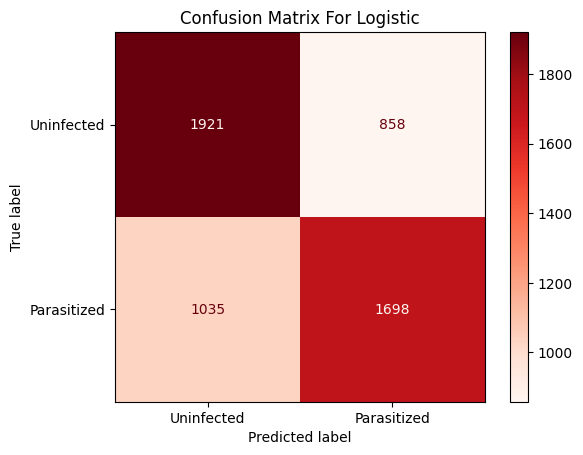

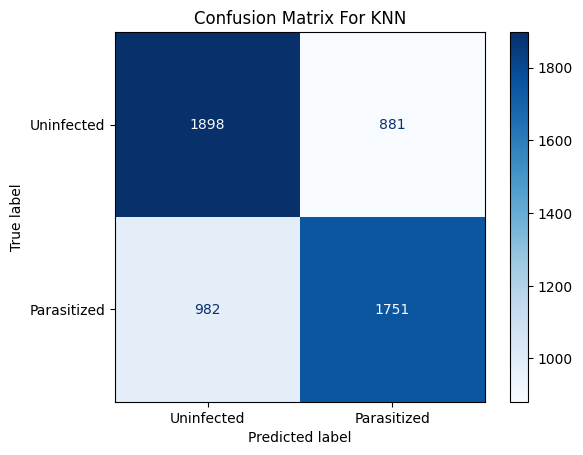

In [70]:
#Logistic
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test,y_log_pred), display_labels=['Uninfected', 'Parasitized'])
disp.plot(cmap=plt.cm.Reds)
plt.title("Confusion Matrix For Logistic")
plt.show()

#KNN
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test,y_knn_pred), display_labels=['Uninfected', 'Parasitized'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix For KNN")
plt.show()

# Plot Loss Curve

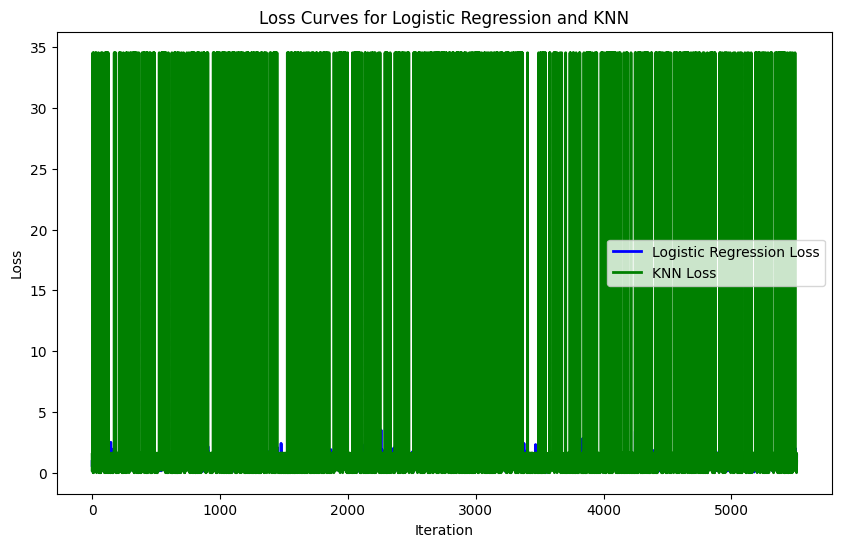

In [73]:

epsilon = 1e-15  # Small value to prevent log(0)

# Logistic Regression Loss Curve
loss_curve_logistic = []
for i, prob in enumerate(log_model.predict_proba(log_X_test)):
    prob = np.clip(prob, epsilon, 1 - epsilon)  # Clip probabilities to avoid log(0)
    loss = -np.mean(y_train[i] * np.log(prob[1]) + (1 - y_train[i]) * np.log(1 - prob[1]))
    loss_curve_logistic.append(loss)

# KNN Loss Curve
loss_curve_knn = []
for i, prob in enumerate(knn_model.predict_proba(knn_X_test)):
    prob = np.clip(prob, epsilon, 1 - epsilon)  # Clip probabilities to avoid log(0)
    loss = -np.mean(y_train[i] * np.log(prob[1]) + (1 - y_train[i]) * np.log(1 - prob[1]))
    loss_curve_knn.append(loss)

# Plotting both loss curves
plt.figure(figsize=(10, 6))
plt.plot(range(len(loss_curve_logistic)), loss_curve_logistic, color='blue', lw=2, label='Logistic Regression Loss')
plt.plot(range(len(loss_curve_knn)), loss_curve_knn, color='green', lw=2, label='KNN Loss')

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Curves for Logistic Regression and KNN')
plt.legend()
plt.show()


# Plot ROC Curve and Calculate AUC

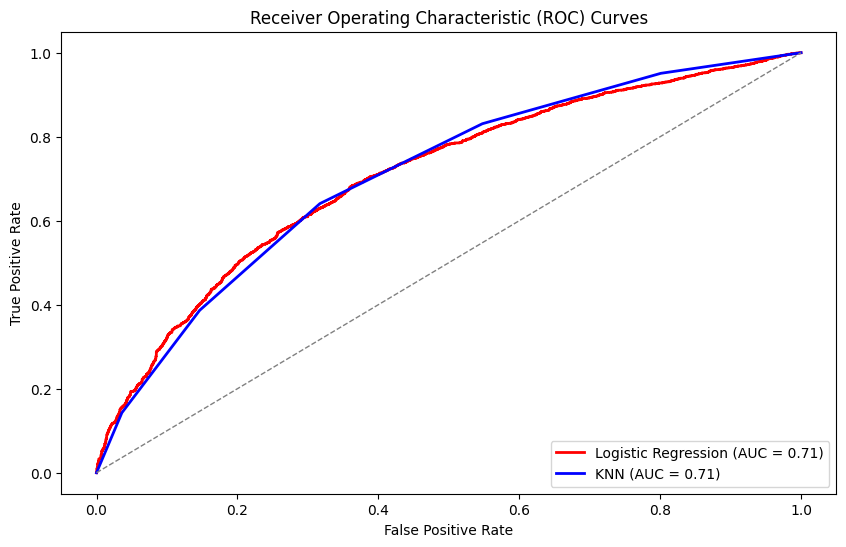

In [74]:
y_pred_proba_logistic = log_model.predict_proba(log_X_test)[:, 1]
fpr_logistic, tpr_logistic, _ = roc_curve(y_test, y_pred_proba_logistic)
roc_auc_logistic = auc(fpr_logistic, tpr_logistic)

y_pred_proba_knn = knn_model.predict_proba(knn_X_test)[:, 1]
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_pred_proba_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)

plt.figure(figsize=(10, 6))

plt.plot(fpr_logistic, tpr_logistic, color='red', lw=2, label=f'Logistic Regression (AUC = {roc_auc_logistic:.2f})')

plt.plot(fpr_knn, tpr_knn, color='blue', lw=2, label=f'KNN (AUC = {roc_auc_knn:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)

# Labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()
